*Loss functions are MSE for generator and BinaryCrossEntropy for Critic.*

# Pretrained GAN

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [3]:
path

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet')

### Crappified data

Prepare the input data by crappifying images.

In [7]:
from crappify import *

Uncomment the first time you run this notebook.

In [8]:
# il = ImageList.from_folder(path_hr)
# parallel(crappifier(path_lr, path_hr), il.items)

For gradual resizing we can change the commented line here.

In [9]:
# a jpeg quality of 10 is shit whereas a quality of 70 is not bad at all.
??crappifier

In [4]:
bs, size = 32, 128
# bs, size = 24, 160
# bs, size = 8, 256
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [5]:
# e ImageImageList is used for generating imges from images as input.
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=9)

In [6]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True) # tfm_y=True means whatever tranform is applied on x same will be applied on y
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True)) # do_y means normalize y variable too.
    data.c=3 # # ? output channels rgb
    return data

In [7]:
data_gen = get_data(bs, size)

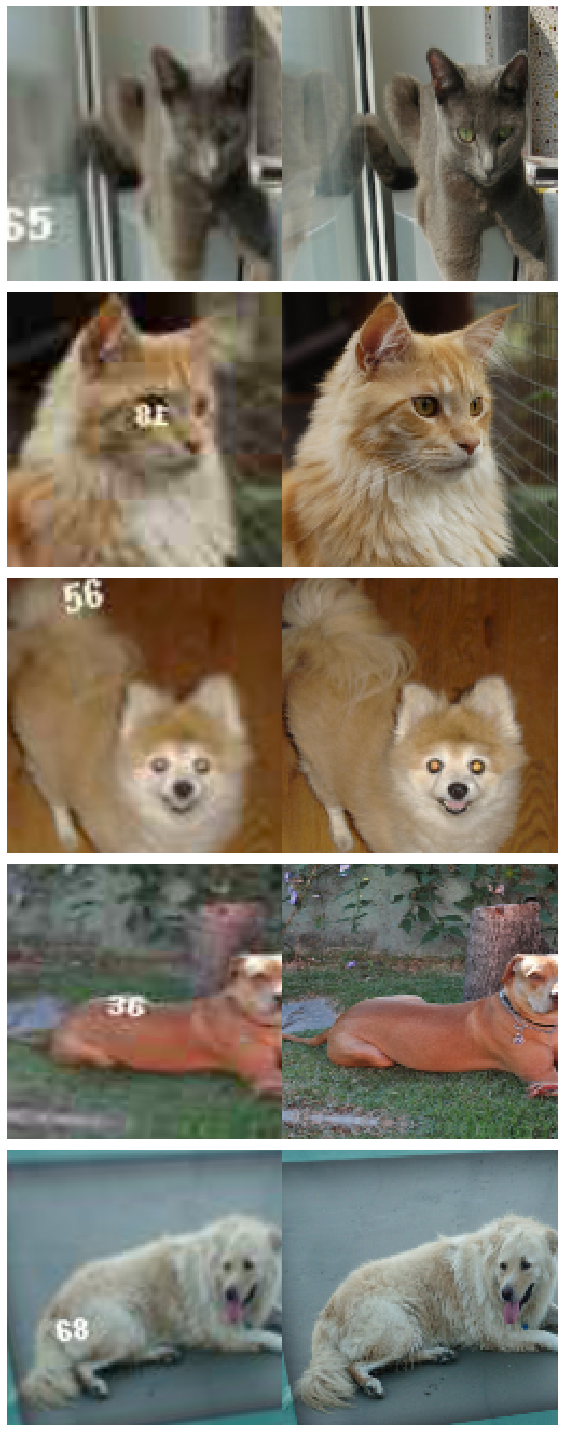

In [14]:
data_gen.show_batch()

In [8]:
wd = 1e-3
y_range = (-3., 3.)

In [9]:
# loss fn expects 2 vectors but in this case we have 2 images so we use MSELossFlat() which simply flattens out
# those images images into a vector.
loss_gen = MSELossFlat()

In [10]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                       self_attention=True, y_range=y_range, loss_func=loss_gen)

Why are we using a pretrained model? Well because if you're going to get rid of watermrks, you need to know what probably is there and to knowthat you have to know what this is a picture of. 

In [11]:
learn_gen = create_gen_learner()

In [16]:
# pct_start is the Percentage of total number of epochs when learning
# rate rises during one cycle.
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [17]:
learn_gen.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


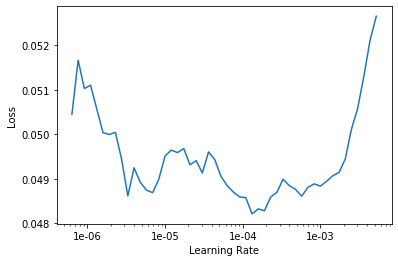

In [18]:
learn_gen.lr_find()
learn_gen.recorder.plot()

In [19]:
learn_gen.fit_one_cycle(3, slice(2e-5, 1e-4))

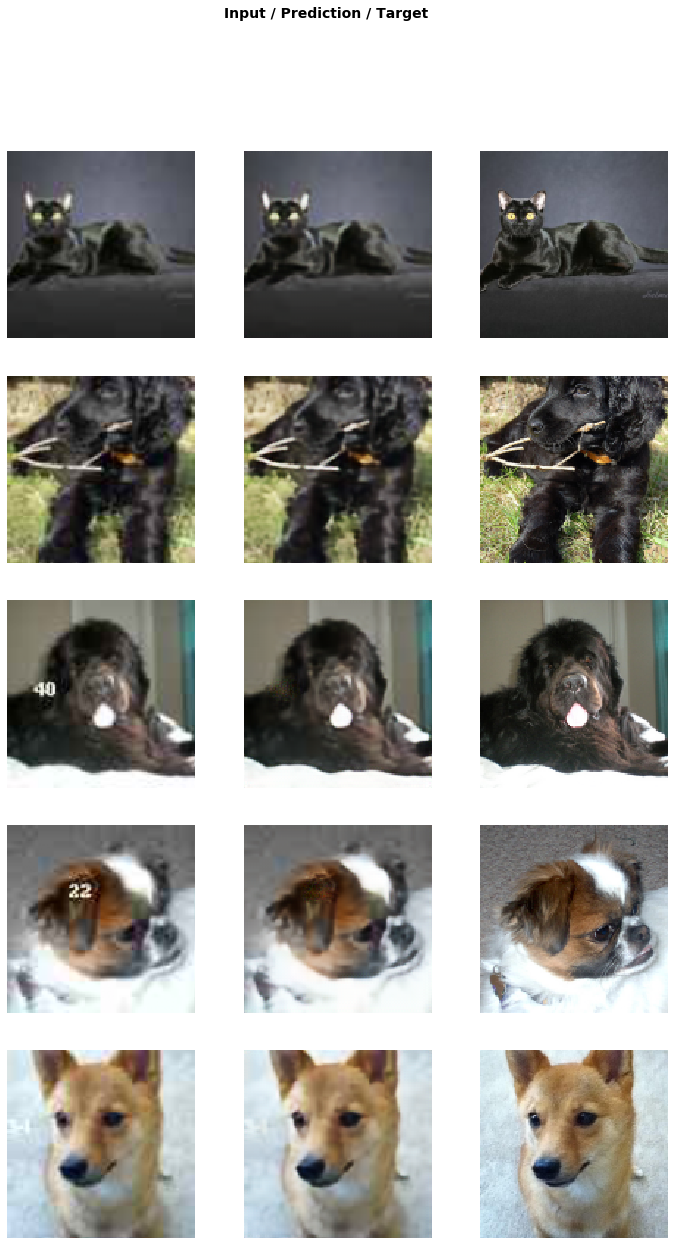

In [20]:
learn_gen.show_results()

In [21]:
learn_gen.save('gen-pre2')

## Save generated images  
for the input to the discriminator/critic

In [12]:
learn_gen.load('gen-pre2')

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, pa

In [13]:
name_gen = 'image_gen'
path_gen = path/name_gen; path_gen

PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/image_gen')

In [14]:
# shutil.rmtree(path_gen)

In [15]:
path_gen.mkdir(exist_ok=True)

In [16]:
def save_preds(dl):
    i=0
    names = dl.dataset.items #getting the filenames present in the dataloader
    
    #iterating through each batch of the dataloader
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True) # reconstruct=True means its gonna create fastai immage objects for each of the items in the batch
        for o in preds: # go through the predictions and save them.
            o.save(path_gen/names[i].name)
            i+=1

In [32]:
data_gen.fix_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f8b03a97750>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f8b7862b440>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=True)], collate_fn=<function data_collate at 0x7f8b0e2607a0>)

In [37]:
data_gen.fix_dl.dataset.items[:5]

array([PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/pomeranian_123.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/Bengal_87.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/Ragdoll_52.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/wheaten_terrier_54.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/samoyed_165.jpg')], dtype=object)

In [36]:
data_gen.dataset.items[:5]

array([PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/pomeranian_123.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/Bengal_87.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/Ragdoll_52.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/wheaten_terrier_54.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/samoyed_165.jpg')], dtype=object)

In [38]:
len(data_gen.dataset.items), len(data_gen.fix_dl.dataset.items)

(6651, 6651)

So they're the same thing then eh

In [27]:
save_preds(data_gen.fix_dl)

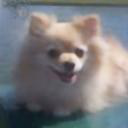

In [28]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [17]:
# You gotta restart your jupyter notebook to reclaim the used memory so one thing you can do is this
learn_gen=None
gc.collect() # it deletes that learn_gen data and frees up memory.

240

Pretrain the critic on crappy vs not crappy.

In [18]:
def get_critic_data(classes, bs, size):
    src= ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed =42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [19]:
name_gen

'image_gen'

In [20]:
data_critic = get_critic_data([name_gen, 'images'], bs=bs, size=size)

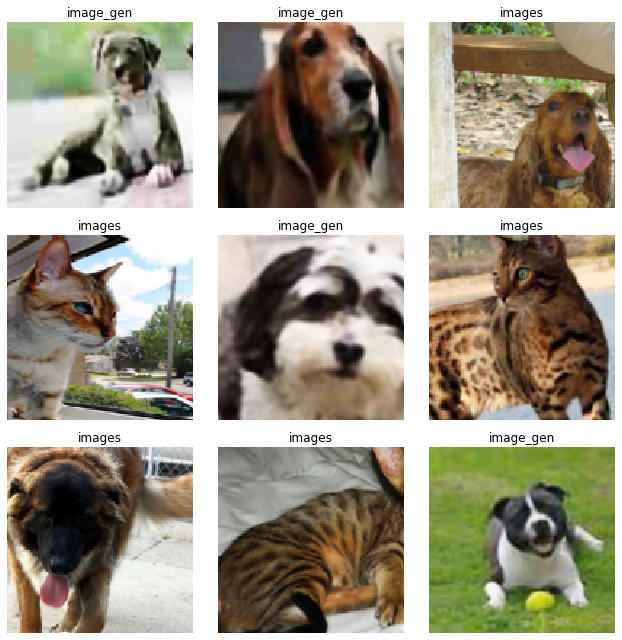

In [49]:
data_critic.show_batch(rows=3, ds_type= DatasetType.Train, imgsize=3)

In [21]:
# we dont use a resnet here[for training critic]. WHY?-> part2
# when doing a gan we need to be careful that the generator and the critic can't
# push in the same direction and increase the weights out of control so we have to
# spectral nnormalization for gans to work
# Using BinaryCrossEntropy 
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [22]:
# a gan_critic uses a slightly different way of averaging the different parts of image when it does the
# loss so when doing gan you gotta wrap your loss_func with AdaptiveLoss. More in Part2
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [23]:
# for similar reasons as above we use a different type of accuracy
learn_critic = create_critic_learner(data_critic, accuracy_thresh_expand)

In [53]:
learn_critic.fit_one_cycle(6, 1e-3)

In [54]:
learn_critic.save('critic-pre2')

### GAN

Now we'll combine those pretrained model in a GAN.

In [24]:
learn_critic = None
learn_gen = None
gc.collect()

20

In [25]:
learn_critic = create_critic_learner(data_critic, metrics=None).load('critic-pre2')

In [26]:
learn_gen = create_gen_learner().load('gen-pre2')

Now that we have pretrained the gen & the critic we now have to ping pong on training them each. The amt of time to train them both with their lrs is still a bit on the fuzzy side so fastai defines a GanLearner for us, where we just pass the two models to it and it'll figure out the details when you call learn.fit.  
  
To define a GAN Learner, we just have to specify the learner objects for the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images). 
  
You can't use only the critic as the loss fn because then the gan would get really good at creating pictures that look like pictures but actually have nothing to do with the original photo so you gotta add the Pixel loss and the critic loss. Those two losses are on different scales so we multiply the pixel loss by 50-200.That is what the weight_gens parameter is for.Something in that range works very well.  
  
Gans hate momemtum because you keep switching between the two models so its kind of tough. So the momemtum value is set to zero in the opt_func parameter(betas=0.)

In [27]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_critic, weights_gen=(1.,50.), show_img=True, switcher=switcher,
                                opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [28]:
lr = 1e-4

The loss numbers for gans are meaningless because as the generator gets better it gets harder for the critic and vice versa. So the numbers should stay about the same. Thats one of the tough things about training gans, that its hard to know how they're doing. The only way to know is to take a look at the results from time to time. The show_img=True parameter in GANLearner prints them from time to time.

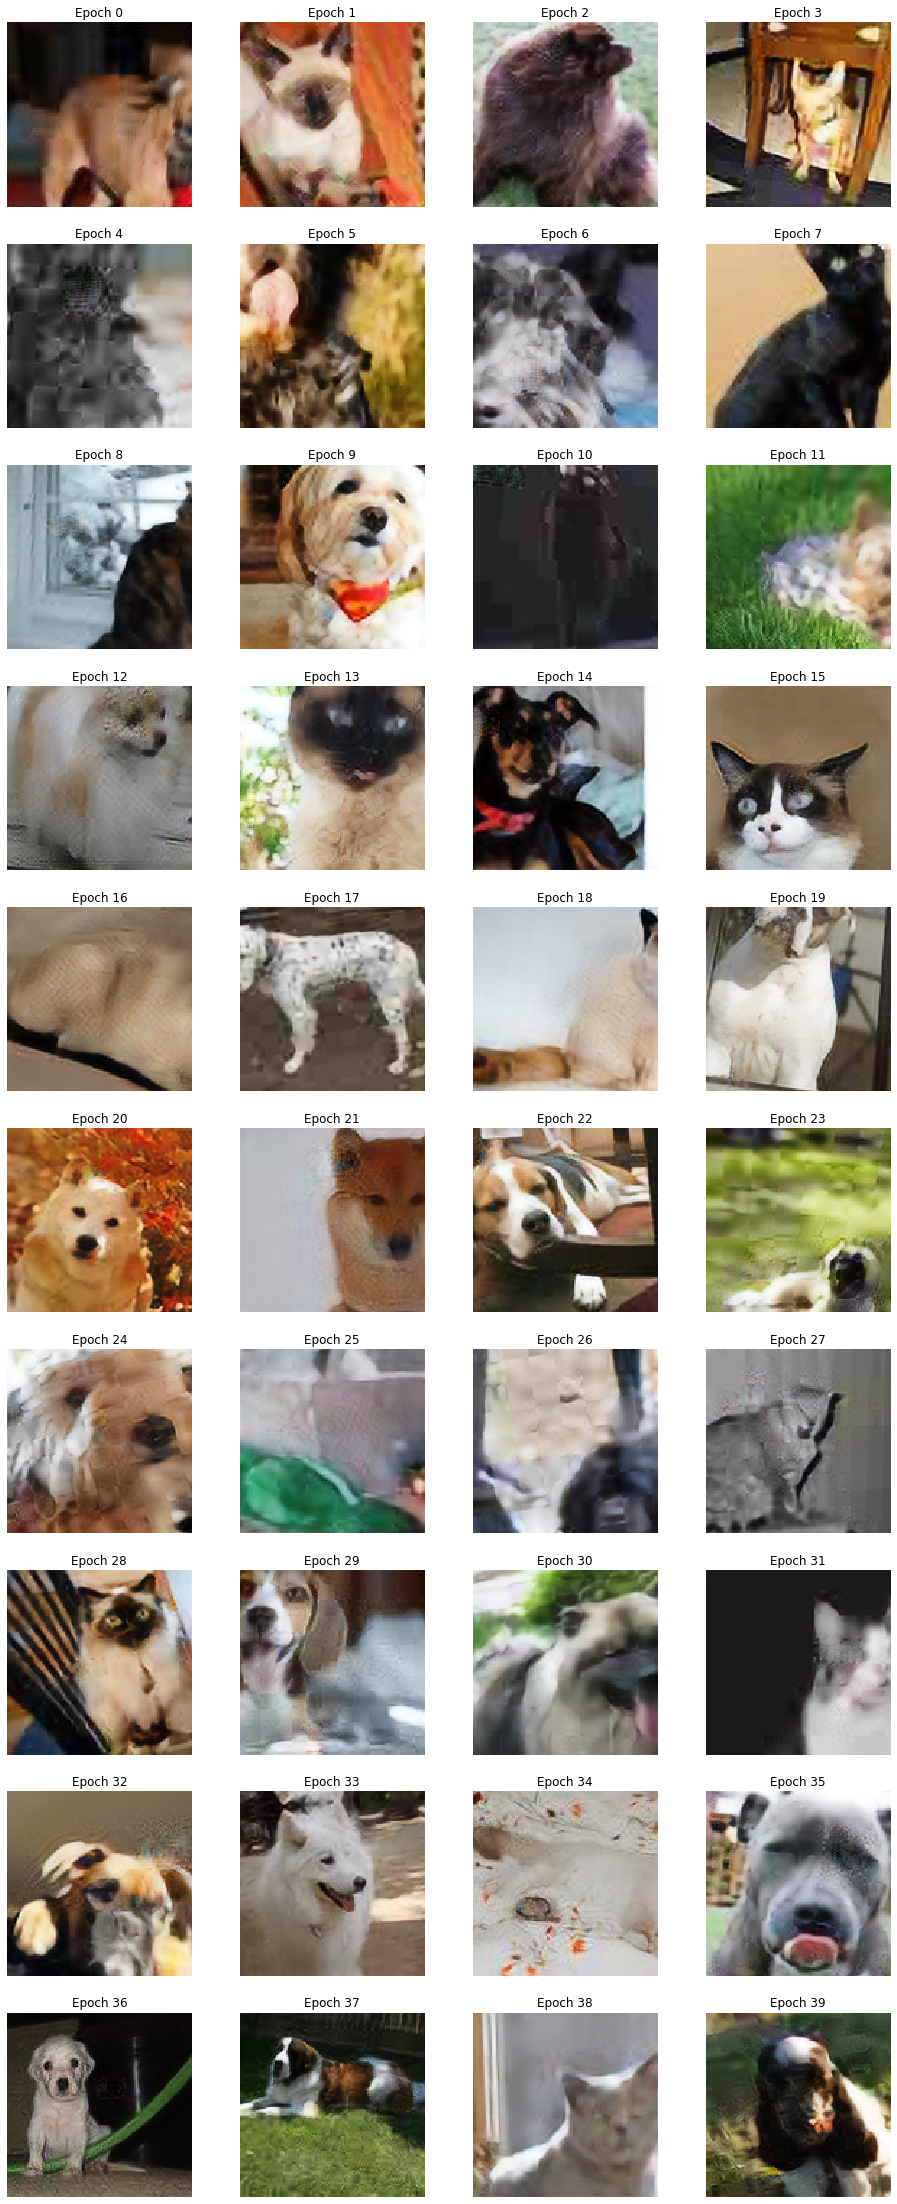

In [29]:
learn.fit(40, lr)

In [30]:
learn.save('gan-1c')

In [31]:
learn.data = get_data(16,192) # progressive resizing

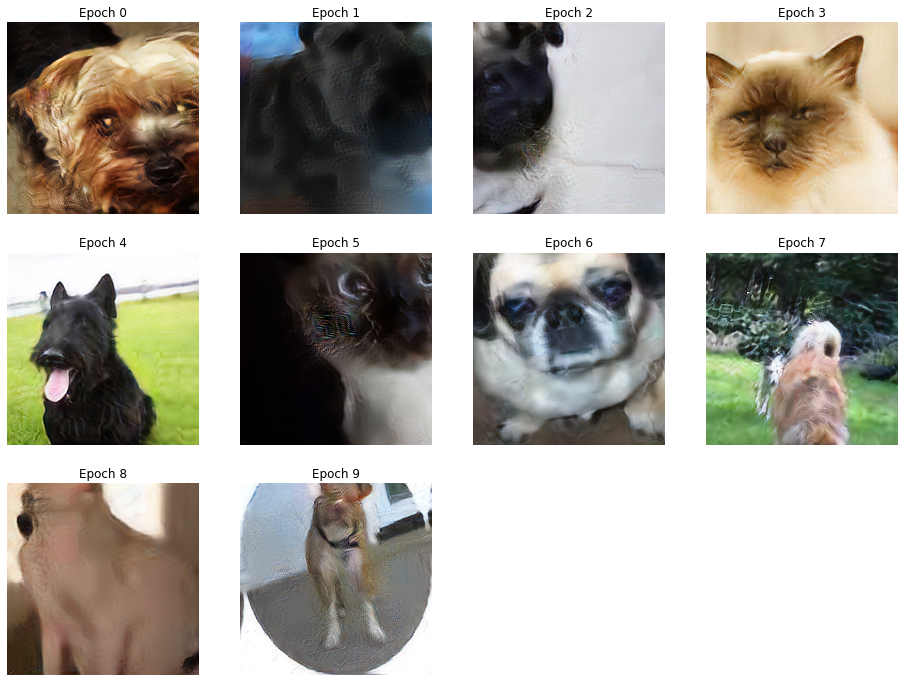

In [32]:
learn.fit(10, lr/2)

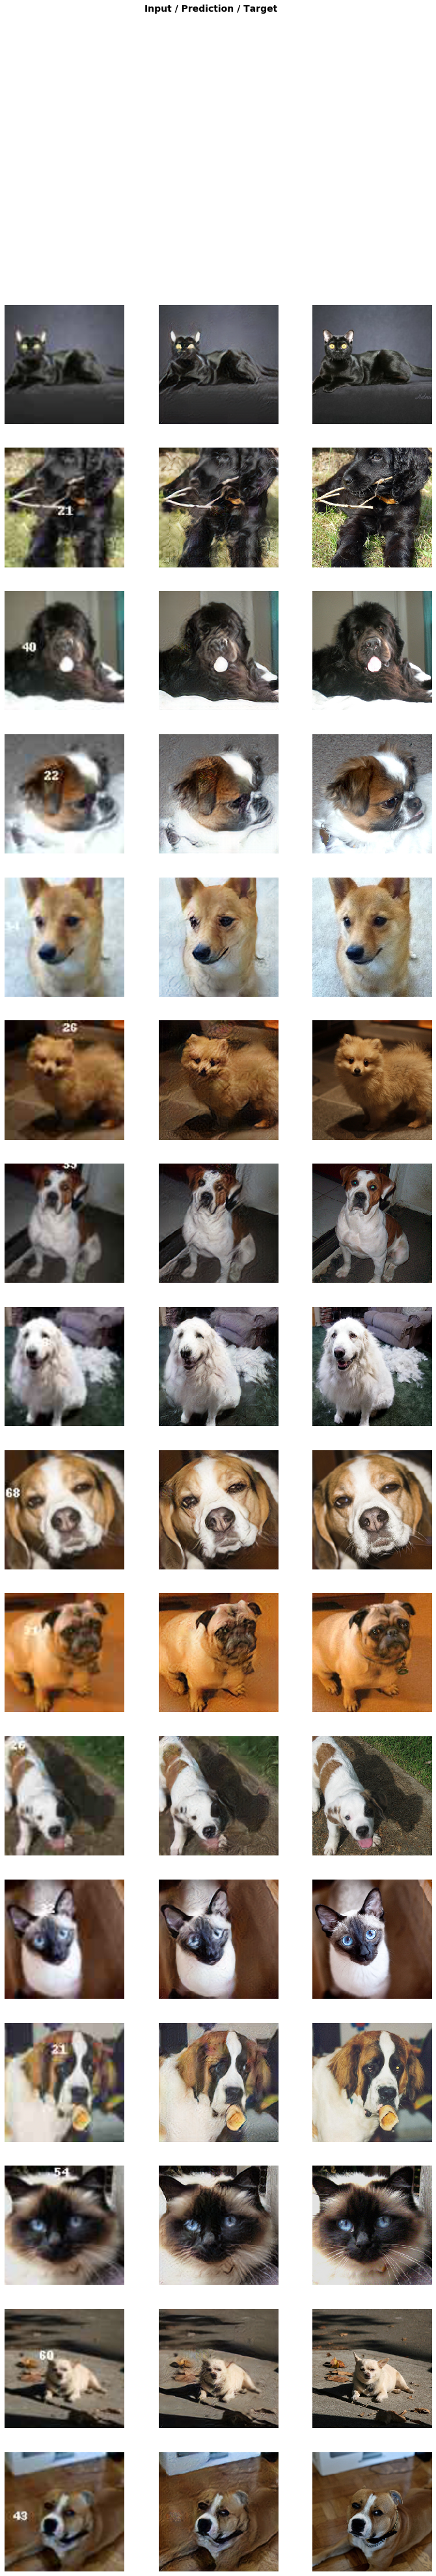

In [33]:
learn.show_results(rows=20)

The result isnt fabulous because the critic doesn't know about eyes so it doesn't care. It does not know that its a feature that matters.  
The critic isn't a pretrained on those things.

In [34]:
learn.save('gan-1c')

## fin